In [1]:
import os, sys
PROJECT_NAME='sm-scraper'
cwd = os.getcwd()
if not cwd.endswith(PROJECT_NAME):
    cwds = cwd.split('/'); i = cwds.index(PROJECT_NAME)
    os.chdir('/'.join(cwds[:i+1]))
    dn = '.'; dn_hack = '/'.join([dn, *cwds[i+1:]]); hn = cwds[-1]

from src.nlp.util import * ; import src.nlp.util as util
import spacy
nlp = spacy.load('en_core_web_sm')

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


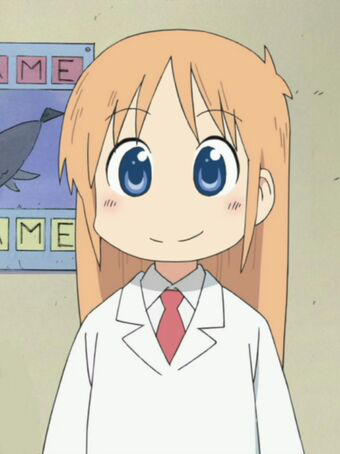

In [2]:
args = Namespace()
args.base = bargs = Namespace(dn=dn, dn_hack=dn_hack, hn=hn, device='cuda')
Image.open('./env/__hakase__.jpg')

In [60]:
pipeline = nlp

In [96]:
# load + split data
stopwords = {
    line.lower() for line in read('./src/nlp/stopwords.txt').split('\n')
    if line and line[0]!='#'
}
if False:
    def get_kwords(fn):
        rows = [row.split('\t') for row in read(fn).split('\n')]
        texts = [f'{row[6]} {row[7]}' for row in rows if len(row)>7]#[:10]
        lemmas = [ [
            token.lemma_.lower()
            for token in pipeline(text)
            if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
        ] for text in texts ]
        lemmas = [lems for lems in lemmas if lems]
        return lemmas
    lems_pos = get_kwords('./env/data/smscraper/police_scraped_data.tsv')
    lems_neg = get_kwords('./env/data/smscraper/all_scraped_data.tsv')
    dump(lems_pos, './data/tfidf/lemmas_pos.pkl')
    dump(lems_neg, './data/tfidf/lemmas_neg.pkl')
else:
    lems_pos = load('./data/tfidf/lemmas_pos.pkl')
    lems_neg = load('./data/tfidf/lemmas_neg.pkl')

In [97]:
np.random.seed(0)
ord_pos = np.random.permutation(np.asarray(lems_pos, dtype=object))
ord_neg = np.random.permutation(np.asarray(lems_neg, dtype=object))
pos_train, pos_test = ord_pos[:-128], ord_pos[-128:]
neg_train, neg_test = ord_neg[:-128], ord_neg[-128:]


In [113]:
print(len(pos_train))
print(len(neg_train))

2531
13112


In [98]:
# construct pipeline
pipe = sklearn.feature_extraction.text.TfidfVectorizer()
tfidf = pipe.fit_transform(
    [' '.join(lems) for lems in pos_train] +
    [' '.join(lems) for lems in neg_train]
)
vocab = {v:k for k,v in pipe.vocabulary_.items()}
dump(pipe, './src/nlp/tfidf/pipe.pkl')


In [99]:
# fit model
model = sklearn.linear_model.LogisticRegression().fit(
    tfidf,
    np.concatenate([
        np.ones(len(pos_train)),
        np.zeros(len(neg_train)),
    ]).astype(np.int),
)
weights = model.coef_.argsort()[0]
weights = [(vocab[idx], model.coef_[0,idx]) for idx in weights]
dump(model, './src/nlp/tfidf/model.pkl')


In [100]:
def classify(docs):
    tfidf = pipe.transform([' '.join(lems) for lems in docs])
    ans = model.predict_proba(tfidf)[:,1]
    return ans

In [101]:
# evaluate
pred = classify(np.concatenate([pos_test, neg_test]))
gt = np.concatenate([
    np.ones(len(pos_test)),
    np.zeros(len(neg_test)),
]).astype(np.int)
pbin = pred>0.5
gbin = gt>0.5
tp = (pbin & gbin).mean()
tn = (~pbin & ~gbin).mean()
fp = (pbin & ~gbin).mean()
fn = (~pbin & gbin).mean()
tab = [
    ['acc::l', (tp+tn,':.6f'),],
    ['pre::l', (tp/(tp+fp),':.6f'),],
    ['rec::l', (tp/(tp+fn),':.6f'),],
    ['f-1::l', (2*tp/(2*tp+fp+fn),':.6f'),],
]
print(Table(tab))


 acc 0.843750 
 pre 0.988889 
 rec 0.695312 
 f-1 0.816514 


In [112]:
# understand weights
n = 50
print(Table([
    #['largest weights', '', ' | ::v', 'smallest weights', ''],
    ['word::l', 'weight', ' | ::v', 'word::l', 'weight'],
    ['=::>'],
]+[
    [(v0,'l'), (w0,':8.4f'), (v1,'l'), (w1,':8.4f'), ]
    for (v0,w0),(v1,w1) in zip(weights[-n:][::-1], weights[:n], )
]))

 word          weight | word           weight 
 police       15.1241 | game          -1.6688 
 cop          11.1297 | cat           -1.3542 
 officer       8.1231 | oc            -1.3298 
 arrest        5.4036 | finally       -1.2240 
 cops          4.3741 | anon          -1.2240 
 sheriff       4.2517 | ve            -1.2084 
 deputy        3.8718 | play          -1.1902 
 shoot         3.8193 | israel        -1.1875 
 law           3.6474 | ape           -1.1821 
 justice       3.3991 | win           -1.0327 
 nypd          3.3425 | draw          -1.0309 
 force         3.3131 | doge          -0.9249 
 enforcement   3.2554 | beautiful     -0.9240 
 department    3.2039 | love          -0.9139 
 county        2.9931 | gay           -0.9051 
 brutality     2.9518 | fan           -0.8938 
 charge        2.8819 | cute          -0.8927 
 video         2.8498 | meme          -0.8814 
 poll          2.8471 | baby          -0.8668 
 crime         2.8276 | gop           -0.8479 
 policing    

In [103]:
# evaluate
pred = np.asarray([
    'police' in doc
    for doc in np.concatenate([pos_test, neg_test])
])
gt = np.concatenate([
    np.ones(len(pos_test)),
    np.zeros(len(neg_test)),
]).astype(np.int)
pbin = pred>0.5
gbin = gt>0.5
tp = (pbin & gbin).mean()
tn = (~pbin & ~gbin).mean()
fp = (pbin & ~gbin).mean()
fn = (~pbin & gbin).mean()
tab[0].append((tp+tn,'r:.6f'))
tab[1].append((tp/(tp+fp),'r:.6f'))
tab[2].append((tp/(tp+fn),'r:.6f'))
tab[3].append((2*tp/(2*tp+fp+fn),'r:.6f'))
tab.insert(0, ['', ' | ::v', 'tfidf::l', 'has_police::l'])
tab.insert(1, ['-::>', ])
# print(Table([
#     ['acc::l', (tp+tn,':.6f'),],
#     ['pre::l', (tp/(tp+fp),':.6f'),],
#     ['rec::l', (tp/(tp+fn),':.6f'),],
#     ['f-1::l', (2*tp/(2*tp+fp+fn),':.6f'),],
# ]))
print(Table(tab))

     | tfidf    has_police 
---------------------------
 acc | 0.843750   0.691406 
 pre | 0.988889   0.980392 
 rec | 0.695312   0.390625 
 f-1 | 0.816514   0.558659 


In [104]:
# testing
def tfidf(text, metadata):
    doc = pipeline(text)
    lemmas = [
        lem
        for lem in [tok.lemma_.lower() for tok in doc]
        if lem and lem.isalpha() and lem not in stopwords
    ]
    x = tfidf_pipe.transform([' '.join(lemmas),])
    prob = tfidf_model.predict_proba(x)[0,1]
    return {
        'relevant': prob>0.5,
        'score': str(int(prob*100)),
    }
tfidf_pipe = load('./src/nlp/tfidf/pipe.pkl')
tfidf_model = load('./src/nlp/tfidf/model.pkl')


In [111]:
tfidf('game bitcoin officer murder crime ', {})

{'relevant': True, 'score': '79'}

# sentiment analysis example

In [3]:
n = 100
stopwords = {
    line for line in read('./data/stopwords.txt').split('\n')
    if line and line[0]!='#'
}
pos = [
    read(f'./data/aclImdb/train/pos/{fn}')
    for fn in sorted(os.listdir('./data/aclImdb/train/pos'))[:n]
]
neg = [
    read(f'./data/aclImdb/train/neg/{fn}')
    for fn in sorted(os.listdir('./data/aclImdb/train/neg'))[:n]
]
unsup = [
    read(f'./data/aclImdb/train/unsup/{fn}')
    for fn in sorted(os.listdir('./data/aclImdb/train/unsup'))[:n]
]

In [4]:
pos_doc = [
    ' '.join([
        token.lemma_.lower() for token in nlp(doc)
        if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
    ]) for doc in pos
]
neg_doc = [
    ' '.join([
        token.lemma_.lower() for token in nlp(doc)
        if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
    ]) for doc in neg
]
unsup_doc = [
    ' '.join([
        token.lemma_.lower() for token in nlp(doc)
        if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
    ]) for doc in unsup
]

In [52]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

if os.path.isfile('./data/tfidf.pkl')
pipe = sklearn.feature_extraction.text.TfidfVectorizer()
tfidf = pipe.fit_transform(pos_doc+neg_doc+unsup_doc)
dump(pipe, './data/tfidf.pkl')

model = sklearn.linear_model.LogisticRegression().fit(
    tfidf[:len(pos)+len(neg)],
    np.concatenate([
        np.ones(len(pos)),
        np.zeros(len(neg)),
    ]).astype(np.int),
)
dump(model, './data/tfidf_model.pkl')

In [43]:
test_pos = [
    read(f'./data/aclImdb/test/pos/{fn}')
    for fn in sorted(os.listdir('./data/aclImdb/test/pos'))[:n]
]
test_neg = [
    read(f'./data/aclImdb/test/neg/{fn}')
    for fn in sorted(os.listdir('./data/aclImdb/test/neg'))[:n]
]


In [50]:
def classify(docs):
    # docs: list of raw text strings
    lem = [
        ' '.join([
            token.lemma_.lower() for token in nlp(doc)
            if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
        ]) for doc in docs
    ]
    tfidf = pipe.transform(lem)
    ans = model.predict(tfidf)
    return ans

In [47]:
test_pos_doc = [
    ' '.join([
        token.lemma_.lower() for token in nlp(doc)
        if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
    ]) for doc in test_pos
]
test_neg_doc = [
    ' '.join([
        token.lemma_.lower() for token in nlp(doc)
        if token.lemma_.isalpha() and token.lemma_.lower() not in stopwords
    ]) for doc in test_neg
]
model.score(
    pipe.transform(test_pos_doc+test_neg_doc),
    np.concatenate([
        np.ones(len(test_pos_doc)),
        np.zeros(len(test_neg_doc)),
    ]).astype(np.int),
)

0.73

In [51]:
np.mean([classify(test_pos_doc).mean(), 1-classify(test_neg_doc).mean()])

0.73